## Overview
#### In this notebook we will explore data around wine ratings and build out a model to determine the quality of new wines

##### 1. Our data engineering team will use scala to prepare the data and store the resulting table in delta lake
##### 2. Our data sceince team will pick up the table, and build out several models in python to then deploy to mlflow

In [7]:
#Latest changes made by *LOCAL IDE*
import datetime
import pytz
est = pytz.timezone("US/Eastern")
timestamp = str(datetime.datetime.now(est))[5:19]
print ("Last Run at: ", timestamp)

Last Run at:  03-30 12:23:32


In [1]:
!pwd

/Users/elliott.botwick@ibm.com/Documents/Python/Gittesting/cpd25/assets/jupyterlab


In [2]:
!ls project_data_assets/data_asset

ls: project_data_assets/data_asset: No such file or directory


In [3]:
!ls 

WineExploration.ipynb


In [4]:
!pip install pyspark

In [5]:
from pyspark import *

In [6]:
conf = SparkConf()
# # .setAppName(appName).setMaster(master)
sc = SparkContext(conf=conf)

Exception: Java gateway process exited before sending its port number

In [54]:
from pyspark.sql import SparkSession

In [56]:
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [57]:
sc.getConf().getAll()

[('spark.driver.port', '37745'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host',
  'jupyter-lab-512a3254-fe04-4559-b9b8-86bb36e32261-85dd799f7dxlkp'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1583337467532'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

In [59]:
# File location and type
file_location = "/home/wsuser/work/project_data_assets/data_asset/winemag-data_first150k.csv_shaped_1cdeecc6.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df.head()

# import pandas as pd
# data = pd.read_csv(file_location)

Row(country='US', designation="Martha's Vineyard", points=96, price=235, province='California', region_1='Napa Valley', region_2='Napa', variety='Cabernet Sauvignon', winery='Heitz', descriptionLen=355)

In [62]:
df.show(5)

+-------+--------------------+------+-----+--------------+-----------------+-----------------+------------------+--------------------+--------------+
|country|         designation|points|price|      province|         region_1|         region_2|           variety|              winery|descriptionLen|
+-------+--------------------+------+-----+--------------+-----------------+-----------------+------------------+--------------------+--------------+
|     US|   Martha's Vineyard|    96|  235|    California|      Napa Valley|             Napa|Cabernet Sauvignon|               Heitz|           355|
|  Spain|Carodorum Selecci...|    96|  110|Northern Spain|             Toro|             null|     Tinta de Toro|Bodega Carmen Rod...|           318|
|     US|Special Selected ...|    96|   90|    California|   Knights Valley|           Sonoma|   Sauvignon Blanc|            Macauley|           280|
|     US|             Reserve|    96|   65|        Oregon|Willamette Valley|Willamette Valley|      

In [68]:
df.groupBy("points").count().orderBy(("points")).show(21)

+------+-----+
|points|count|
+------+-----+
|    80|  883|
|    81| 1469|
|    82| 3933|
|    83| 5807|
|    84|10120|
|    85|11604|
|    86|14351|
|    87|19025|
|    88|16034|
|    89|11557|
|    90|14404|
|    91| 9211|
|    92| 8119|
|    93| 5197|
|    94| 3007|
|    95| 1466|
|    96|  567|
|    97|  303|
|    98|  114|
|    99|   40|
|   100|   24|
+------+-----+



In [7]:
%scala 
import scala.util.{Try, Success, Failure}

val couldIbeAnInteger = udf((value: String) => Try(value.toInt).isSuccess)
val filteredDF = dfscala.filter((couldIbeAnInteger($"points")))
  .withColumn("price",col("price").cast(IntegerType))
  .withColumn("points",col("points").cast(IntegerType))


import scala.util.{Try, Success, Failure}
couldIbeAnInteger: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,BooleanType,Some(List(StringType)))
filteredDF: org.apache.spark.sql.DataFrame = [country: string, description: string ... 8 more fields]

In [72]:
# %scala
# display(filteredDF.groupBy("points").count().orderBy(desc("points")))

In [9]:
%scala
import org.apache.spark.sql.sources.IsNull


for (c <- filteredDF.columns) println(c + " has " + filteredDF.filter(filteredDF(c).isNull).count() + " null values")

country has 5 null values
description has 0 null values
designation has 45729 null values
points has 0 null values
price has 13689 null values
province has 5 null values
region_1 has 25053 null values
region_2 has 89958 null values
variety has 0 null values
winery has 0 null values
import org.apache.spark.sql.sources.IsNull

In [10]:
%scala
display(filteredDF.select("points", "price"))

points,price
96,235
96,110
96,90
96,65
95,66
95,73
95,65
95,110
95,65
95,60


In [11]:
%scala
val finalDF = filteredDF.withColumn("DescriptionLen", length('description))

display(finalDF.select("points", "DescriptionLen").orderBy("points").sample(false, 0.0065))

points,DescriptionLen
80,270
80,134
80,98
80,135
80,174
81,149
81,170
81,113
81,136
81,213


In [12]:
%scala

spark.sql("CREATE TABLE IF NOT EXISTS winedelta USING DELTA LOCATION '/delta/winedelta'")
finalDF.write.format("delta").mode("overwrite").save("/delta/winedelta")


In [13]:
%scala
val wine = spark.read.format("delta").load("/delta/winedelta")

wine: org.apache.spark.sql.DataFrame = [country: string, description: string ... 9 more fields]

In [14]:
%sql
OPTIMIZE delta.`delta/winedelta`
  ZORDER BY (region_2)

path,metrics
delta/winedelta,"List(List(23498100, 23498100, 2.34981E7, 1, 23498100), List(1243083, 3357411, 3046660.0, 8, 24373282), 0, List(minCubeSize(107374182400), List(0, 0), List(8, 24373282), 0, List(8, 24373282), 0), 1)"


In [15]:
%scala

for (c <- wine.columns) println(c + " has " + wine.filter(wine(c).isNull).count() + " null values")

country has 5 null values
description has 0 null values
designation has 45729 null values
points has 0 null values
price has 13689 null values
province has 5 null values
region_1 has 25053 null values
region_2 has 89958 null values
variety has 0 null values
winery has 0 null values
DescriptionLen has 0 null values

### \/\/\/\/ Hand off to data science team for Python work \/\/\/\/

In [80]:
df.dtypes

[('country', 'string'),
 ('designation', 'string'),
 ('points', 'int'),
 ('price', 'int'),
 ('province', 'string'),
 ('region_1', 'string'),
 ('region_2', 'string'),
 ('variety', 'string'),
 ('winery', 'string'),
 ('descriptionLen', 'int')]

In [81]:
pywine = df

In [82]:
import pandas as pd
display(pywine.toPandas().corr())

,points,price,descriptionLen
points,1.000000,0.459863,0.557353
price,0.459863,1.000000,0.254884
descriptionLen,0.557353,0.254884,1.000000


In [84]:
pywine.groupBy("country").max("price").orderBy("max(price)", ascending = False).show()

+------------+----------+
|     country|max(price)|
+------------+----------+
|      France|      2300|
|          US|      2013|
|     Austria|      1100|
|    Portugal|       980|
|       Italy|       900|
|   Australia|       850|
|     Germany|       775|
|       Spain|       770|
|     Hungary|       764|
|       Chile|       400|
|     Romania|       320|
|   Argentina|       250|
|      Israel|       150|
|      Canada|       145|
|South Africa|       145|
| New Zealand|       125|
|      Greece|       120|
|      Turkey|       120|
|      Mexico|       108|
|    Slovenia|        90|
+------------+----------+
only showing top 20 rows



In [85]:
pywine = pywine.filter(pywine.country.isNotNull()).filter(pywine.price.isNotNull()).filter(pywine.province.isNotNull()).filter(pywine.region_1.isNotNull())

#filter out all rows that have a null value for Country, Price, Province, or Region_1

In [87]:
collist = pywine.columns
collist.remove("points")
collist.remove("price")
collist.remove("descriptionLen")
collist.remove("designation")
collist.remove("region_2")

#dropping designation and region_2 based on null count 

In [88]:
collist

['country', 'province', 'region_1', 'variety', 'winery']

In [89]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import *

#define stringindexer to cast fraud_flag column to 'label' for mllib models
strindexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in collist]
stringpipe = Pipeline().setStages(strindexers).fit(pywine).transform(pywine)

In [93]:
feature_vec = stringpipe.columns[(len(stringpipe.columns)-len(strindexers)):len(stringpipe.columns)]
feature_vec.append('price')
feature_vec.append('descriptionLen')
feature_vec

['country_index',
 'province_index',
 'region_1_index',
 'variety_index',
 'winery_index',
 'price',
 'descriptionLen']

In [94]:
# SET UP PIPELINE

assemble_features = VectorAssembler(inputCols=feature_vec, outputCol="features")
winePipe =Pipeline().setStages([assemble_features]).fit(stringpipe).transform(stringpipe)
winePipe = winePipe.withColumnRenamed("points", "label")
winePipe.describe

<bound method DataFrame.describe of DataFrame[country: string, designation: string, label: int, price: int, province: string, region_1: string, region_2: string, variety: string, winery: string, descriptionLen: int, country_index: double, province_index: double, region_1_index: double, variety_index: double, winery_index: double, features: vector]>

In [95]:
train,test =winePipe.randomSplit([0.7, 0.3])

In [96]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10)

# Fit the model
lrModel = lr.fit(train)
yhat = lrModel.transform(test)

In [97]:
# !pip install -U scikit-learn
import sklearn.metrics

lrr2 = sklearn.metrics.r2_score(test.select("label").collect(),yhat.select("prediction").collect())

lrr2

0.4519565443472999

In [98]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10)

# Fit the model
glrModel = glr.fit(winePipe)
glrYhat = glrModel.transform(test)

In [99]:
glrr2 = sklearn.metrics.r2_score(test.select("label").collect(),glrYhat.select("prediction").collect())
glrr2

0.4522153576275115

In [100]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col, avg, stddev

#Set max categories to 4 so any indexed variable with greater than 4 categories will be treated as continuous
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(winePipe)

transformedData = featureIndexer.transform(winePipe)
transformedData = transformedData.drop("features")
transformedData= transformedData.withColumn("features", col("indexedFeatures"))

training,testing =transformedData.randomSplit([0.7, 0.3])

rf = RandomForestRegressor()

# Chain indexer and forest in a Pipeline
rfPipe = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
rfModel = rfPipe.fit(training)

# Make predictions.
rfYhat = rfModel.transform(testing)

In [101]:
rfr2 = sklearn.metrics.r2_score(testing.select("label").collect(),rfYhat.select("prediction").collect())
rfr2

0.5552029622837193

In [102]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
kmModel = kmeans.fit(winePipe)

# Make predictions
clusterpreds = kmModel.transform(winePipe)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(clusterpreds)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = kmModel.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.8488685621805035
Cluster Centers: 
[1.45256113e+00 8.87585845e+00 1.42637855e+02 2.23755304e+01
 6.36569949e+03 3.19043786e+01 2.35235641e+02]
[9.56747367e-01 5.44882664e+00 8.51634292e+01 1.70467487e+01
 1.09066121e+03 3.53456387e+01 2.45325897e+02]


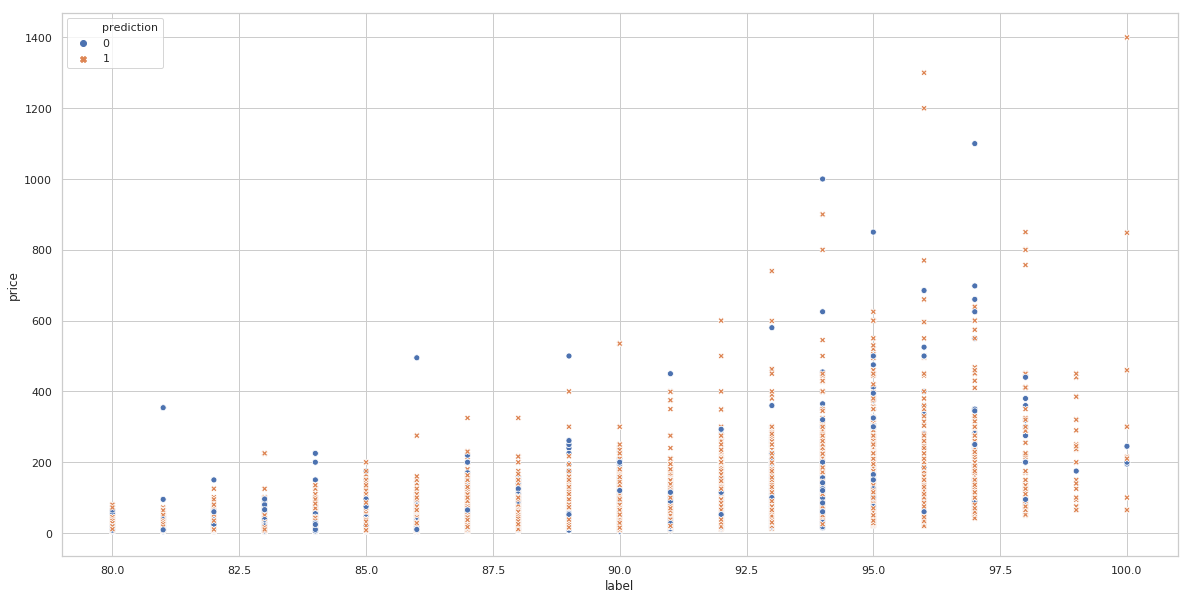

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
clusterpd =  clusterpreds.select("price" ,"label", "prediction").toPandas()
clustpdFilt = clusterpd[clusterpd['price']<1500]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize = (20, 10))
figure = sns.scatterplot(x = "label", y = "price", hue = "prediction", style = "prediction", x_jitter = True, y_jitter = True, data = clustpdFilt)
# sns.set(style="whitegrid", palette = sns.palplot("muted"))


In [104]:
clusterpd.groupby("prediction").describe()

price                                                       \
              count       mean        std  min   25%   50%   75%     max   
prediction                                                                 
0           22861.0  31.904379  39.535592  4.0  15.0  23.0  38.0  2300.0   
1           91532.0  35.345639  36.646343  4.0  17.0  26.0  42.0  1900.0   

              label                                                      
              count       mean       std   min   25%   50%   75%    max  
prediction                                                               
0           22861.0  87.283102  3.174826  80.0  85.0  87.0  90.0  100.0  
1           91532.0  87.997913  3.296088  80.0  86.0  88.0  90.0  100.0

In [110]:
from IPython.display import IFrame    
IFrame("https://giphy.com/gifs/go-american-outlaws-ZFJYcVE5lYvWE/fullscreen" , width="800", height="500")


## Extra unused cells and viz for dashboard

In [39]:
display(pywine.select("country", "variety", "points").filter(col("variety") == "Malbec"))

country,variety,points
Argentina,Malbec,87
Argentina,Malbec,89
Argentina,Malbec,89
France,Malbec,89
France,Malbec,89
Argentina,Malbec,90
Argentina,Malbec,90
Argentina,Malbec,90
Argentina,Malbec,87
Argentina,Malbec,89


In [40]:
display(pywine.select("region_1", "price", "winery").filter(col("region_1") == "Napa Valley").orderBy("price", ascending = False).limit(50))

region_1,price,winery
Napa Valley,625,Yao Ming
Napa Valley,625,Yao Ming
Napa Valley,500,Harlan Estate
Napa Valley,450,Harlan Estate
Napa Valley,350,Harlan Estate
Napa Valley,335,Bryant Family
Napa Valley,300,Cardinale
Napa Valley,300,Hundred Acre
Napa Valley,300,Hundred Acre
Napa Valley,300,Hundred Acre


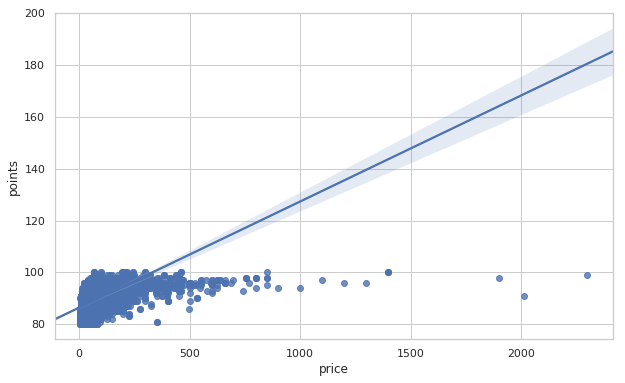

In [111]:
import seaborn as sns
sns.set(style="whitegrid")
fig1, ax1 = plt.subplots(figsize = (10, 6))
seaborn1 = sns.regplot("price", "points", data = pywine.toPandas())
# display(seaborn1)